# Report 
This notebook serves to create the results and analyze the strategy of this project. 

### Pre-processing Steps 
You need to run the steps to extract the data and download it and create the business cycle indicator. To do so, you need to run: 

**Fetch Data from FRED and Yahoo Finance**
python src/cli/cli.py fetch --macro --trade
**Construct Business Cycle Indicator**
python src/cli/cli.py business-cycle


In [4]:
import pandas as pd
import sys
sys.path.append("..")
from trade import core
from ingress import core as ingress_core
from importlib import reload
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
import pandas as pd 
import numpy as np
reload(core)
reload(ingress_core)

<module 'ingress.core' from '/Users/noahforougi/research/factor_rotation/src/results/../ingress/core.py'>

### 1. Create Strategic DataFrame

In [2]:
factor_prices = ingress_core.read_csv_from_s3("etf_data.csv")
bci = ingress_core.read_csv_from_s3("business_cycle_indicator.csv")


In [3]:
strategic_dataframe = core.create_strategy(factor_prices, bci)

### 2. Exploratory Data Analysis

Business Cycle Plot

/var/folders/h6/x8xtcdbj30q6yb889t6pcbq00000gn/T/ipykernel_83213/1032794235.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif phase != df['Cycle_Phase'][index - 1] or index == len(df['Cycle_Phase']) - 1:
/var/folders/h6/x8xtcdbj30q6yb889t6pcbq00000gn/T/ipykernel_83213/1032794235.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  color = 'green' if df['Cycle_Phase'][index - 1] == 'Expansion' else 'red'


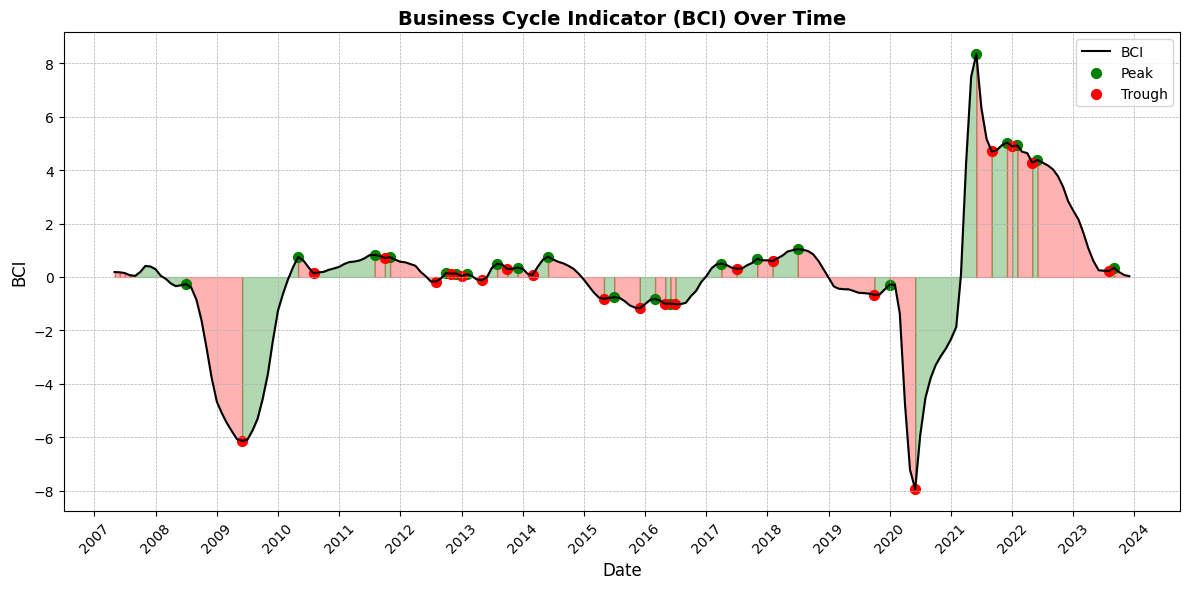

In [5]:
df = bci.assign(date = lambda x: pd.to_datetime(x.date)).set_index("date")

# Create columns for peaks (end of expansion) and troughs (end of contraction)
df['Peak'] = (df['Cycle_Phase'].shift(1) == 'Expansion') & (df['Cycle_Phase'] == 'Contraction')
df['Trough'] = (df['Cycle_Phase'].shift(1) == 'Contraction') & (df['Cycle_Phase'] == 'Expansion')

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))

# Plot BCI with black line
ax.plot(df.index, df['BCI'], label='BCI', color='black', linewidth=1.5)

# Shading
start = None
for index, phase in enumerate(df['Cycle_Phase']):
    if start is None:
        start = df.index[index]
    elif phase != df['Cycle_Phase'][index - 1] or index == len(df['Cycle_Phase']) - 1:
        end = df.index[index]
        color = 'green' if df['Cycle_Phase'][index - 1] == 'Expansion' else 'red'
        ax.fill_between(df.index, 0, df['BCI'], where=(df.index >= start) & (df.index <= end), color=color, alpha=0.3)
        start = end

# Marking peaks and troughs
ax.scatter(df.index[df['Peak']], df['BCI'][df['Peak']], color='green', label='Peak', s=50)
ax.scatter(df.index[df['Trough']], df['BCI'][df['Trough']], color='red', label='Trough', s=50)

# Enhance x-axis
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)

# Add grid
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Title and labels
ax.set_title('Business Cycle Indicator (BCI) Over Time', fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('BCI', fontsize=12)
ax.legend()

# Show plot
plt.tight_layout()
plt.show()


In [14]:
# Assuming factor_prices is your DataFrame
# Convert 'Date' to datetime and set as index
data = factor_prices.assign(Date = lambda x: pd.to_datetime(x.Date.astype(str).str.slice(0,10)).dt.date).set_index("Date").sort_index().dropna().pct_change()
data.head()
# Calculate cumulative returns for each factor
cumulative_returns = (1 + data).cumprod()

In [15]:
cumulative_returns

,value,growth,quality,momentum,low_vol
Date,,,,,
2011-10-20,NaN,NaN,NaN,NaN,NaN
2011-10-21,1.018268,1.020232,1.016369,1.017589,1.012224
2011-10-24,1.030778,1.037148,1.030506,1.035607,1.012224
2011-10-25,1.009928,1.016584,1.012649,1.013299,1.008675
2011-10-26,1.024226,1.023383,1.020089,1.016302,1.013013
...,...,...,...,...,...
2023-12-06,3.877408,5.610860,4.728521,3.595950,3.802032
2023-12-07,3.886340,5.678199,4.764294,3.614313,3.805014
2023-12-08,3.901767,5.705627,4.786309,3.638946,3.803523


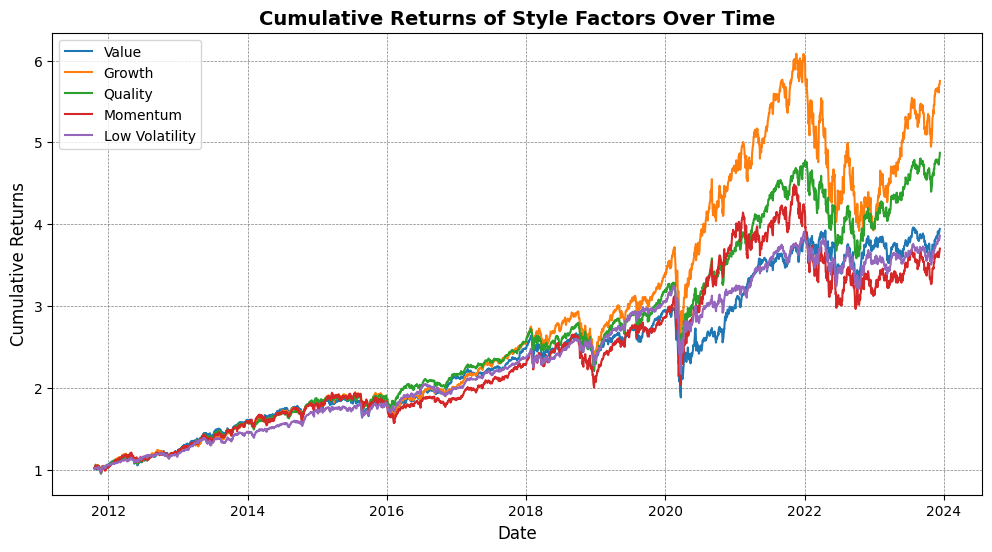

In [22]:
# Plotting
fig, ax = plt.subplots(figsize=(12, 6))

# Define a color palette
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:pink']

ax.plot(cumulative_returns.index, cumulative_returns["value"], label="Value", color=colors[0])
ax.plot(cumulative_returns.index, cumulative_returns["growth"], label="Growth", color=colors[1])
ax.plot(cumulative_returns.index, cumulative_returns["quality"], label="Quality", color=colors[2])
ax.plot(cumulative_returns.index, cumulative_returns["momentum"], label="Momentum", color=colors[3])
ax.plot(cumulative_returns.index, cumulative_returns["low_vol"], label="Low Volatility", color=colors[4])

# Add grid, title, labels, and legend with a professional look
ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='grey')
ax.set_title('Cumulative Returns of Style Factors Over Time', fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Cumulative Returns', fontsize=12)
ax.legend()


### 3. Analysis of Strategy Performance vs Benchmark 

In [28]:
data = strategic_dataframe.assign(date = lambda x: pd.to_datetime(x.date)).set_index("date")

Plot of cumulative returns of each strategy

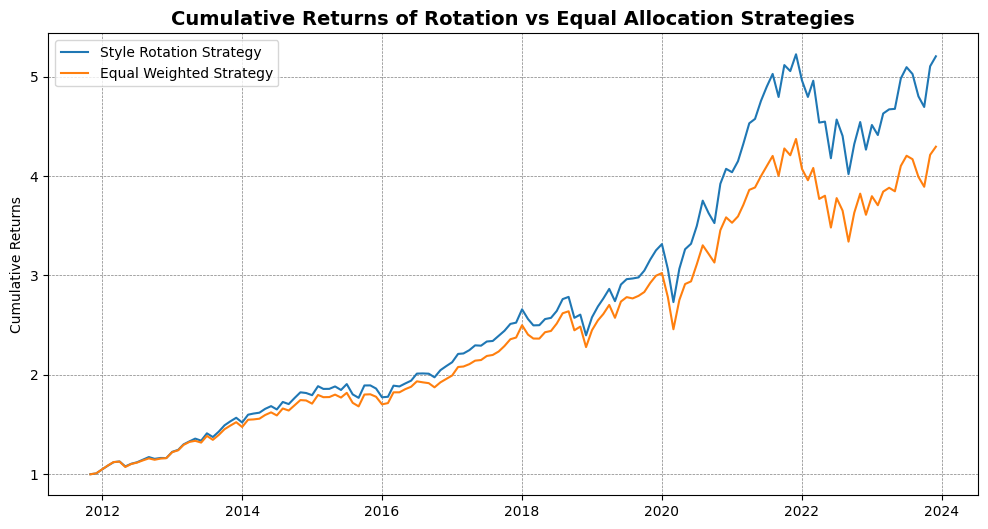

In [36]:
data = data.assign(strategy_cum_ret = lambda x:  (1 + x.strategy_returns).cumprod(), 
                   equal_cum_ret = lambda x:  (1 + x.equal_weight_returns).cumprod())
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(data.index, data.strategy_cum_ret, label = "Style Rotation Strategy")
ax.plot(data.index, data.equal_cum_ret, label = "Equal Weighted Strategy")
ax.legend()
ax.set_title("Cumulative Returns of Rotation vs Equal Allocation Strategies", fontsize=14, fontweight='bold')
ax.set_ylabel("Cumulative Returns")
ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='grey')


In [65]:
# Calculate additional statistics
annualized_returns = data[['strategy_returns', 'equal_weight_returns']].mean() * 12
annualized_std = data[['strategy_returns', 'equal_weight_returns']].std() * np.sqrt(12)
sharpe_ratio = (annualized_returns-0.0230) / annualized_std
rolling_max_strategy = data['strategy_cum_ret'].cummax()
rolling_max_equal_weight = data['equal_cum_ret'].cummax()
drawdown_strategy = data['strategy_cum_ret'] / rolling_max_strategy - 1
drawdown_equal_weight = data['equal_cum_ret'] / rolling_max_equal_weight - 1
max_drawdown_strategy = drawdown_strategy.min()
max_drawdown_equal_weight = drawdown_equal_weight.min()

stats_df_cleaned = pd.DataFrame({
    'Annualized Return': annualized_returns,
    'Annualized Std Dev': annualized_std,
    'Sharpe Ratio': sharpe_ratio,
    'Max Drawdown': [max_drawdown_strategy, max_drawdown_equal_weight]
}, index=['My Strategy', 'Equal Weight Strategy'])

In [66]:
pd.DataFrame(data ={
    'Annualized Return': annualized_returns,
    'Annualized Std Dev': annualized_std,
    'Sharpe Ratio': sharpe_ratio,
    'Max Drawdown': [max_drawdown_strategy, max_drawdown_equal_weight]
})

,Annualized Return,Annualized Std Dev,Sharpe Ratio,Max Drawdown
strategy_returns,0.145577,0.136421,0.898515,-0.23077
equal_weight_returns,0.129381,0.134390,0.791585,-0.23613
